## Complexity Metrics of Cyber Network
##### Gabe Weaver, 3.15.19
For this experiment, we are going to consider the structural complexity of a cyber network.  A snippet of the network is shown below.

![](images/city_of_arcoTest.png)

In [45]:
from edu.illinois.iti.dao.CommunicationsNetworkDAO import IMNCommunicationsNetworkDAO
import json
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# 1.  Read in the network
networkFilePath = "../data/testing/city_of_arcoTest.imn"
cnDAO = IMNCommunicationsNetworkDAO.create(networkFilePath)
gCyber = cnDAO.getNetwork(networkFilePath)

### 2.  Compute Complexity Metrics
In this step, we compute complexity metrics on the graph.  When a complexity metric is applied to a graph, the implementation will decorate that graph with an attribute whose value is the output of that metric.

#### Degree
The degree of a node is a simple measure to understand its importance.

In [46]:
def computeNodeDegrees(G):
    """
    Decorate nodes in the graph with an attribute 
      name 'nx:in_degree', 'nx:out_degree'.  The value 
      of this attribute is an integer that is the 
      degree of the node.
    """
    for nIdx in G.nodes():
        node = G.nodes[nIdx]
        node['nx:in_degree'] = G.in_degree(nIdx)
        node['nx:out_degree'] = G.out_degree(nIdx)
        node['gc:degree'] = G.in_degree(nIdx) + G.out_degree(nIdx)
    return G    

def computeBetweennessCentrality(G):
    bcDict = nx.betweenness_centrality(G)
    for nIdx in G.nodes():
        node = G.nodes[nIdx]
        node['nx:betweenness_centrality'] = bcDict[nIdx]
    return G

def computeClosenessCentrality(G):
    ccDict = nx.closeness_centrality(G)
    for nIdx in G.nodes():
        node = G.nodes[nIdx]
        node['nx:closeness_centrality'] = ccDict[nIdx]
    return G

def computeDegreeCentrality(G):
    dcDict = nx.degree_centrality(G)
    for nIdx in G.nodes():
        node = G.nodes[nIdx]
        node['nx:degree_centrality'] = dcDict[nIdx]
    return G

def computeBridges(G):
    """
    Must compute bridges on an undirected graph so 
      we first convert
    """
    undirectedGCyber = G.to_undirected()
    bridges = nx.bridges(undirectedGCyber)
    
    for bridge in bridges:
        sIdx = bridge[0]
        tIdx = bridge[1]
        if G.has_edge(sIdx, tIdx):   
            G[sIdx][tIdx]["nx:bridge"] = True
        elif G.has_edge(tIdx, sIdx):
            G[tIdx][sIdx]["nx:bridge"] = True
        else:
            print("Could not find {0} - {1} edge.".format(sIdx, tIdx))
    return G

def computeMetrics(G, metrics):
    for metric in metrics:
        if "gc:degree" == metric:
            computeNodeDegrees(G)
        elif "nx:betweenness_centrality" == metric:
            computeBetweennessCentrality(G)
        elif "nx:degree_centrality" == metric:
            computeDegreeCentrality(G)
        elif "nx:closeness_centrality" == metric:
            computeClosenessCentrality(G)
        elif "nx:bridge" == metric:
            computeBridges(G)
        else:
            raise NotImplementedError() 
    return

## 4.  See How Complexity Metrics Affect Performance Measures


In [66]:
# Compute complexity metrics of interest
metrics = ["gc:degree", "nx:betweenness_centrality", \
           "nx:closeness_centrality", "nx:degree_centrality", \
           "nx:bridge"]
computeMetrics(gCyber, metrics)

# Sort nodes by a metric value 
nodes = gCyber.nodes(data=True)
edges = gCyber.edges(data=True)
#sNodes = sorted(nodes, key=lambda x: x[1]['nx:degree_centrality'], reverse=True)

df = pd.DataFrame()
for node in nodes:
    nodeData = node[1]
    nodeData["nx:id"] = node[0]
    row = pd.Series( nodeData )
    df = df.append(row, ignore_index=True)

### Node Degree
So with respect to the degree metric, we should be looking at the effect of disrupting the assets in the table above on some Key Performance Indicators within the water treatment plant's cyber network.  

From looking at the table below:
* RJ45PP-02-01 connects the Plant 1 Operation's Room to the Plant 1 Computer room
* ENS-02-03 is in the Plant 1 Computer Room
* ENS-5-1 is in the Plant 2 Operations Room

Observation:  Looks like if we use degree, most of these are switches.

In [4]:
df.sort_values(by=["gc:degree"], ascending=False).head(10)

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
10,7.0,RJ45PP-02-1,e0,lanswitch,n11,0.002797,0.038341,0.049296,5.0,2.0
2,6.0,ENS-02-3,e0,lanswitch,n3,0.000000,0.000000,0.042254,0.0,6.0
89,6.0,ENS-5-1,e0,lanswitch,n90,0.000000,0.000000,0.042254,0.0,6.0
66,5.0,ENS-13-1,e0,lanswitch,n67,0.001398,0.016432,0.035211,1.0,4.0
18,5.0,ENS-15-1,e0,lanswitch,n19,0.001398,0.040597,0.035211,3.0,2.0
68,5.0,ENS-14-1,e0,lanswitch,n69,0.002497,0.022007,0.035211,2.0,3.0
15,5.0,ENS-2-1,e0,lanswitch,n16,0.001648,0.042606,0.035211,4.0,1.0
22,5.0,ENS-12-1,e0,lanswitch,n23,0.000450,0.015845,0.035211,2.0,3.0
43,4.0,ENS-9-3,e0,lanswitch,n44,0.003446,0.010563,0.028169,1.0,3.0
70,4.0,ENS-11-1,e0,lanswitch,n71,0.000499,0.009390,0.028169,1.0,3.0


This does make sense due the definition of a Switch.  If we get rid of the switches, we get rid of most of the high-degree nodes.  We should note here that the type of the Firewalls, AppServer, and PLCs are all `router` in the water treatment dataset.  I'm not sure whether this is an error.

In [5]:
switch_mask = (df["imn:type"] != "lanswitch")
df[ switch_mask ].sort_values(by=["gc:degree"], ascending=False).head(10)

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
0,2.0,FWL-02-1,eth0,router,n1,0.00025,0.007042,0.014085,1.0,1.0
1,2.0,FWL-02-2,eth0,router,n2,0.00040,0.009390,0.014085,1.0,1.0
141,1.0,AppServer,eth0,router,n143,0.00000,0.011268,0.007042,1.0,0.0
88,1.0,PLC-5B,eth0,router,n89,0.00000,0.007042,0.007042,1.0,0.0
100,1.0,PLC-1-20,eth0,router,n101,0.00000,0.010563,0.007042,1.0,0.0
99,1.0,PLC-1-21,eth0,router,n100,0.00000,0.009390,0.007042,1.0,0.0
98,1.0,PLC-1-22,eth0,router,n99,0.00000,0.007042,0.007042,1.0,0.0
97,1.0,PLC-1-16,eth0,router,n98,0.00000,0.010563,0.007042,1.0,0.0
96,1.0,PLC-1-15,eth0,router,n97,0.00000,0.009390,0.007042,1.0,0.0
95,1.0,PLC-1-14,eth0,router,n96,0.00000,0.007042,0.007042,1.0,0.0


### Centrality
#### Betweenness Centrality
As stated by the NetworkX API:  "Betweenness centrality of a node $v$ is the sum of the fraction of all-pairs shortest paths that pass through $v$".  The larger the score, the more one could potentially intercept communications between two points (assuming shortest path aligns with routing protocol). 


In [6]:
df.sort_values(by=["nx:betweenness_centrality"], ascending=False).head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
45,4.0,ENS-9-5,e0,lanswitch,n46,0.004245,0.011737,0.028169,1.0,3.0
50,4.0,ENS-9-6,e0,lanswitch,n51,0.004195,0.012072,0.028169,1.0,3.0
44,4.0,ENS-9-4,e0,lanswitch,n45,0.003996,0.011268,0.028169,1.0,3.0
49,4.0,ENS-9-7,e0,lanswitch,n50,0.003846,0.012324,0.028169,1.0,3.0
43,4.0,ENS-9-3,e0,lanswitch,n44,0.003446,0.010563,0.028169,1.0,3.0


In [7]:
df[ switch_mask ].sort_values(by=["nx:betweenness_centrality"], ascending=False).head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
1,2.0,FWL-02-2,eth0,router,n2,0.00040,0.009390,0.014085,1.0,1.0
0,2.0,FWL-02-1,eth0,router,n1,0.00025,0.007042,0.014085,1.0,1.0
141,1.0,AppServer,eth0,router,n143,0.00000,0.011268,0.007042,1.0,0.0
91,0.0,n90,0,pseudo,n92,0.00000,0.000000,0.000000,0.0,0.0
101,1.0,PLC-1-19,eth0,router,n102,0.00000,0.011268,0.007042,1.0,0.0


#### Closeness Centrality
According to the NetworkX API, closeness centrality of a node $u$ is the average shortest path distance to $u$ from all $n-1$ reachable nodes.  Perhaps this could be useful for susceptibility to lateral movement.

In [8]:
df.sort_values(by=["nx:closeness_centrality"], ascending=False).head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
15,5.0,ENS-2-1,e0,lanswitch,n16,0.001648,0.042606,0.035211,4.0,1.0
18,5.0,ENS-15-1,e0,lanswitch,n19,0.001398,0.040597,0.035211,3.0,2.0
10,7.0,RJ45PP-02-1,e0,lanswitch,n11,0.002797,0.038341,0.049296,5.0,2.0
137,1.0,HMI-15-1,eth0,router,n141,0.000000,0.032337,0.007042,1.0,0.0
136,1.0,OIT-15-1,eth0,router,n142,0.000000,0.032337,0.007042,1.0,0.0


What is interesting here is that most of the switches are in the Zinc Orthophosphate part of the network.  We could possibly do this visual analysis in an automated way in the future if desired.

In [9]:
df[switch_mask].sort_values(by=["nx:closeness_centrality"], ascending=False).head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
137,1.0,HMI-15-1,eth0,router,n141,0.0,0.032337,0.007042,1.0,0.0
136,1.0,OIT-15-1,eth0,router,n142,0.0,0.032337,0.007042,1.0,0.0
28,1.0,PRT-2-3,eth0,router,n29,0.0,0.021939,0.007042,1.0,0.0
29,1.0,NAS,eth0,router,n30,0.0,0.021939,0.007042,1.0,0.0
27,1.0,ZC-2-2,eth0,router,n28,0.0,0.021939,0.007042,1.0,0.0


This is an interesting result.  The reason is because the first two entries are in the CP-ZO, PLC-15 part of the network while the last three entries are in the Chief Operator's Office.  This seems to indicate that these are susceptible to lateral movement if one agrees with the above interpretation of the metric.

#### Degree Centrality


In [10]:
df.sort_values(by=["nx:degree_centrality"], ascending=False).head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
10,7.0,RJ45PP-02-1,e0,lanswitch,n11,0.002797,0.038341,0.049296,5.0,2.0
2,6.0,ENS-02-3,e0,lanswitch,n3,0.000000,0.000000,0.042254,0.0,6.0
89,6.0,ENS-5-1,e0,lanswitch,n90,0.000000,0.000000,0.042254,0.0,6.0
66,5.0,ENS-13-1,e0,lanswitch,n67,0.001398,0.016432,0.035211,1.0,4.0
18,5.0,ENS-15-1,e0,lanswitch,n19,0.001398,0.040597,0.035211,3.0,2.0


In [11]:
df[ switch_mask ].sort_values(by=["nx:degree_centrality"], ascending=False).head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:in_degree,nx:out_degree
0,2.0,FWL-02-1,eth0,router,n1,0.00025,0.007042,0.014085,1.0,1.0
1,2.0,FWL-02-2,eth0,router,n2,0.00040,0.009390,0.014085,1.0,1.0
141,1.0,AppServer,eth0,router,n143,0.00000,0.011268,0.007042,1.0,0.0
88,1.0,PLC-5B,eth0,router,n89,0.00000,0.007042,0.007042,1.0,0.0
100,1.0,PLC-1-20,eth0,router,n101,0.00000,0.010563,0.007042,1.0,0.0


### Bridges
"A *bridge* in a graph is an edge whose removal causes the number of connected components of the graph to increase."  This can be done on an undirected graph.  Therefore, we need to convert the graph to an undirected graph. 

In [19]:
eDf = pd.DataFrame()
for edge in edges:
    edgeData = edge[2]
    edgeData["source"] = edge[0]
    edgeData["target"] = edge[1]
    row = pd.Series( edgeData )
    eDf = eDf.append(row, ignore_index=True)
    
# Give me the edges that aren't bridges
bridge_mask = ( eDf["nx:bridge"] != 1 ) 
eDf[bridge_mask].head()

,name,nx:bridge,source,target


As we can see, this wasn't particularly helpful.  All edges in this graph are bridges.

### Communicability
This is a measure that takes into account the sum of closed walks of different lengths starting at node $u$ and ending at node $v$.  This could be useful if aligned with how packets are routed between nodes.

Unlike the previous measures, this is not a measure that is a node or edge attribute, but rather a measure tied to pairs of nodes.  

If we could align this with how packets are routed, this may be an ingredient to measure *resilience* in terms of the number of different ways one could route traffic between two points. 

For example, if I had some computers $U$ that depended upon a service (e.g. NTP) running on a server $s$, I would want to make sure that the communicability between ${u,v}$ for $u \in U$ was high.  Otherwise, it could become easy to cut off the a node from the service.  Alternatively, if I had multiple nodes running a service, I could collapse those nodes into a supernode $V$ and consider the communicability between ${u,V}$ for $u \in U$.  

#### Communicability of PLCs 
For example, I may be concerned about the communicability between PLCs in the Water Treatment plant and HMIs.  We can look at that below. 

In [53]:
commDict = nx.communicability(gCyber.to_undirected())

In [92]:
#commKeys = communicabilityDict.keys()
#commDf = pd.DataFrame.from_dict(commDict)
#commDf.head()
plc_mask = df["imn:hostname"].str.contains("PLC")
plcDf = df[plc_mask]

# 1. Take a PLC of interest (maybe via another metric)
plcDf.sort_values(by=["nx:degree_centrality"], ascending=False)
plcDf.head()

# Let's take a look at PLC-15A as it was in an area with high 
#   closeness centrality and this may be tied to susceptibility 
#   to lateral movement 
plcId = 18

(array([133.,   4.,   0.,   3.,   1.,   0.,   0.,   0.,   1.,   1.]),
 array([-3.00475223e-16,  2.11679276e-01,  4.23358551e-01,  6.35037827e-01,
         8.46717102e-01,  1.05839638e+00,  1.27007565e+00,  1.48175493e+00,
         1.69343420e+00,  1.90511348e+00,  2.11679276e+00]),
 <a list of 10 Patch objects>)

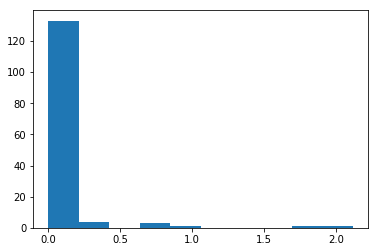

In [93]:
# 2. Determine with whom else it communicates (services)
#     this set could be filtered down
V = commDict[ plcId ]

# 3. Compute communicability for that set of machines
plt.hist(V.values())

We can see that overall, the communicability score for this PLC is low for the machines on which we filter.  The goal would be to shift the distribution rightward for key services.  If machines in $V$ with key services are low, then we would want to do what we can to make the routes from the PLC to $v \in V$ more resilient.

We can also see, according to the topology, which machines have the most communicability with other machines in the network.  This can be interesting to also identify 'communities' as defined in the orginal paper by Estrada and Hatano. We see this in the result below.

In [95]:
V_big = {k: v for k, v in V.items() if v >= 0.5}
id_mask = (df["nx:id"].isin(V_big.keys()))
df[id_mask].head()

,gc:degree,imn:hostname,imn:interface,imn:type,name,nx:betweenness_centrality,nx:closeness_centrality,nx:degree_centrality,nx:id,nx:in_degree,nx:out_degree
15,5.0,ENS-2-1,e0,lanswitch,n16,0.001648,0.042606,0.035211,16.0,4.0,1.0
16,1.0,PLC-15B,eth0,router,n17,0.000000,0.000000,0.007042,17.0,0.0,1.0
17,1.0,PLC-15A,eth0,router,n18,0.000000,0.000000,0.007042,18.0,0.0,1.0
18,5.0,ENS-15-1,e0,lanswitch,n19,0.001398,0.040597,0.035211,19.0,3.0,2.0
136,1.0,OIT-15-1,eth0,router,n142,0.000000,0.032337,0.007042,142.0,1.0,0.0


#### Communicability of the System
In general, it would be interesting to see the distribution of communicability scores over the entire set of pairs of nodes.  So when we plot this, we can see that for the most part, communicability stays low.

(array([1.9602e+04, 4.4400e+02, 2.7500e+02, 7.9000e+01, 1.3000e+01,
        2.8000e+01, 4.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-1.51359185e-15,  7.82740181e-01,  1.56548036e+00,  2.34822054e+00,
         3.13096072e+00,  3.91370090e+00,  4.69644108e+00,  5.47918126e+00,
         6.26192145e+00,  7.04466163e+00,  7.82740181e+00]),
 <a list of 10 Patch objects>)

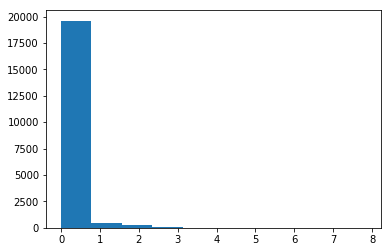

In [114]:
commValues = []
for sourceIdx in commDict.keys():
    if "nx:id" == sourceIdx:
        continue
    targetIdxDict = commDict[sourceIdx]    
    commValues += list(targetIdxDict.values())
plt.hist(commValues)

### 5.  Visualize Critical Nodes
Next in the pipeline will be to visualize critical nodes relative to some metric value.

In [8]:
#  Based on https://plot.ly/python/network-graphs

def plotGraph(G, metricKey, nodeLabelKey):
    pos = nx.get_node_attributes(G,'pos')
    
    #-- Get Node positions
    dmin=1
    ncenter=0
    for n in pos:
        x,y=pos[n]
        d=(x-0.5)**2+(y-0.5)**2
        if d<dmin:
            ncenter=n
            dmin=d

    p=nx.single_source_shortest_path_length(G,ncenter)

    #-- Create Edges
    edge_trace = go.Scatter(
        x=[],
        y=[],
        line=dict(width=0.5,color='#888'),
        hoverinfo='none',
        mode='lines')

    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

    node_trace = go.Scatter(
        x=[],
        y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='YlGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2)))

    for node in G.nodes():
        x, y = G.node[node]['pos']
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        
    # Color Node Points By Metric Value
    for nIdx in G.nodes():
        node = G.nodes[nIdx]
        metricValue = node[metricKey]
        
        labelValue = ""
        if nodeLabelKey in node:
            labelValue = node[nodeLabelKey]
        else:
            print(node)

        node_trace['marker']['color']+=tuple([metricValue])
        node_info = labelValue
        node_trace['text']+=tuple([node_info])

    # Create Network Graph
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
    return fig


In [10]:
plotly.tools.set_credentials_file(username='gweaver', api_key='CWI1yxjAs6jKd2ICgW7y')
plotly.tools.set_config_file(world_readable=True)

# Set node positions according to a layout
nodePositions = nx.spring_layout(gCyber)
for nIdx, posValue in nodePositions.items():
    gCyber.nodes[nIdx]['pos'] = posValue

#computeNodeDegrees(gCyber)
fig = plotGraph(gCyber, metricKey="gc:degree",nodeLabelKey="imn:hostname")
py.iplot(fig, filename='networkx')

/home/tater/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [11]:
fig = plotGraph(gCyber, metricKey="nx:closeness_centrality",nodeLabelKey="imn:hostname")
py.iplot(fig, filename='networkx')